# Japanese simulations analysis

In this notebook, we are going to analyze the datasets coming from the japanese simulations of Nishimichi.
Let us start importing the necessary packages

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/work/example_Effort/notebooks`


In [2]:
using Statistics
using Plots, BenchmarkTools, Random
using LaTeXStrings
using Distributions
using SimpleChains
using Static
using NPZ
using StatsPlots
using ForwardDiff
using LinearAlgebra
using Statistics
using ProgressMeter
using Turing
using Pathfinder
using Optim
using AdvancedHMC

In [3]:
using Effort
using BlindedChallenge

First: let us decide if we are going to use lagrangian or optimal resummation

In [4]:
resum = "optimal"
if resum == "lagrangian"
    println("You choose lagrangian resummation!")
elseif resum == "optimal"
    println("You choose optimal resummation!")
else
    error("You didn't choose a viable resummation!")
end

You choose optimal resummation!


In [5]:
rescale_cov = false
if rescale_cov
    println("You decided to rescale the covariance cov!")
    scaling_factor = 4
    scaling_name = "_scaled_"
else
    println("You decided not to rescale the covariance!")
    scaling_factor = 1
    scaling_name = ""
end;

You decided not to rescale the covariance!


Let us load the trained Effort emulators for the blinded challenge.

In [6]:
if resum == "optimal"
    folder = "../trained_emulators/PyBird_061_10000_optiresum_final/"
elseif resum == "lagrangian"
    folder = "../trained_emulators/PyBird_061_10000_lagrangian_guido_spectra_check/"
else
    error("You didn't choose a viable resummation!")
end

"../trained_emulators/PyBird_061_10000_optiresum_final/"

In [7]:
k_grid = npzread(folder*"k_grid.npy")

function load_component(component, ℓ, folder, k_grid)
    if component == "11"
        k_number = 60
    elseif component == "loop"
        k_number = 240
    elseif component == "ct"
        k_number = 120
    else
        error("You didn't choose a viable component!")
    end
    mlpd = SimpleChain(
      static(3),
      TurboDense(tanh, 64),
      TurboDense(tanh, 64),
      TurboDense(tanh, 64),
      TurboDense(tanh, 64),
      TurboDense(tanh, 64),
      TurboDense(identity, k_number)
    )

    weights = npzread(folder*"weights_P_"*component*"_l_"*string(ℓ)*".npy")
    outMinMax = npzread(folder*"outMinMax_P_"*component*"_l_"*string(ℓ)*".npy")
    inMinMax = npzread(folder*"inMinMax_l_"*string(ℓ)*".npy")

    sc_emu = Effort.SimpleChainsEmulator(Architecture = mlpd, Weights = weights)
    if component == "11"
        comp_emu = Effort.P11Emulator(TrainedEmulator = sc_emu, kgrid = k_grid,
               InMinMax=inMinMax, OutMinMax = outMinMax)
    elseif component == "loop"
        comp_emu = Effort.PloopEmulator(TrainedEmulator = sc_emu, kgrid = k_grid,
               InMinMax=inMinMax, OutMinMax = outMinMax)
    elseif component == "ct"
        comp_emu = Effort.PctEmulator(TrainedEmulator = sc_emu, kgrid = k_grid,
               InMinMax=inMinMax, OutMinMax = outMinMax)
    else
        error("You didn't choose a viable component!")
    end
    return comp_emu
end

function load_multipole(ℓ, folder, k_grid)
    P11 = load_component("11", ℓ, folder, k_grid)
    Ploop = load_component("loop", ℓ, folder, k_grid)
    Pct = load_component("ct", ℓ, folder, k_grid)
    emulator = Effort.PℓEmulator(P11 = P11, Ploop = Ploop, Pct = Pct)
    return emulator
end

load_multipole (generic function with 1 method)

In [8]:
Mono_Emu = load_multipole(0, folder, k_grid)
Quad_Emu = load_multipole(2, folder, k_grid);

# The likelihood

In [9]:
function theory(θ, n, Mono_Emu, Quad_Emu)
    # θ[1:3] cosmoparams, ln_10_As, H0, ΩM
    # θ[4:9] bias
    # θ[10:11] stoch
    #f = fN(θ[3], 0.61)
    f = Effort._f_z(0.61, θ[3], -1., 0.);
    #conversion from c2-c4 to b2-b4
    b2 = (θ[5]+θ[7])/√2
    b4 = (θ[5]-θ[7])/√2
    my_θ = deepcopy(θ)
    my_θ[8] /= (0.7^2)
    my_θ[9] /= (0.7^2)
    n_bar = 3e-4 #value  that has been suggested by Guido himself
    k_bins = Effort.create_bin_edges(BlindedChallenge.k_grid)
    #stoch_0, stoch_2 = Effort.get_stoch_terms(0, θ[10], θ[11], n_bar, k_grid)
    stoch_0, stoch_2 = Effort.get_stoch_terms_binned_efficient(0., my_θ[10], my_θ[11], n_bar, k_bins)
    return vcat((Effort.get_Pℓ(my_θ[1:3], vcat(my_θ[4], b2, my_θ[6], b4, my_θ[8:9] , 0), f, Mono_Emu) .+ stoch_0)[1:n],
                (Effort.get_Pℓ(my_θ[1:3], vcat(my_θ[4], b2, my_θ[6], b4, my_θ[8:9] , 0), f, Quad_Emu) .+ stoch_2)[1:n])
end

theory (generic function with 1 method)

In [10]:
@benchmark theory(ones(11), 20, Mono_Emu, Quad_Emu)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  33.757 μs …  3.419 ms  ┊ GC (min … max): 0.00% … 96.03%
 Time  (median):     36.728 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   39.208 μs ± 64.780 μs  ┊ GC (mean ± σ):  3.22% ±  1.93%

      ▃▆██▇▅▃▃                                                 
  ▁▂▃▆█████████▇▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  33.8 μs         Histogram: frequency by time          52 μs <

 Memory estimate: 33.62 KiB, allocs estimate: 343.

# Turing & Pathfinder

We are now ready to write our loglikelihood!
We are going to employ Turing.jl, a Probabilistic Programming Language (PPL) written in Julia.
Our model can be conveniently written using the `@model` macro.
It is quite easy to write the priors with this formalism. The priors employed in this analysis are the same used by Guido in its analysis
- $b_1$ $\sim$ $\mathrm{Uniform}$ $(0, 4)$
- $c_2$ $\sim$ $\mathrm{Uniform}$ $(-4, 4)$
- $b_3$ $\sim$ $\mathcal{N}(0,10)$ 
- $c_4$ $\sim$ $\mathcal{N}(0,2)$
- $c_\mathrm{ct}$ $\sim$ $\mathcal{N}(0,4)$
- $c_\mathrm{r1}$ $\sim$ $\mathcal{N}(0,8)$
- $c_{\epsilon,m}$ $\sim$ $\mathcal{N}(0,2)$
- $c_{\epsilon,q}$ $\sim$ $\mathcal{N}(0,4)$

In [11]:
@model function pplmodel(data, cov, n, Mono_Emu, Quad_Emu)
    ln10As ~ Uniform(2.9, 3.15)
    H0     ~ Uniform(62.,68.)
    ΩM     ~ Uniform(0.30, 0.34)
    b1     ~ Uniform(0., 4.)
    c2     ~ Uniform(-4., 4.)
    b3     ~ Normal(0., 10.)
    c4     ~ Normal(0., 2.)
    cct    ~ Normal(0., 4.)
    cr1    ~ Normal(0., 8.)
    cϵm    ~ Normal(0., 2.)
    cϵq    ~ Normal(0., 4.)

    θ = [ln10As, H0, ΩM, b1, c2, b3, c4, cct, cr1, cϵm, cϵq]

    prediction = theory(θ, n, Mono_Emu, Quad_Emu)

    data ~ MvNormal(prediction, cov)
    return nothing
end

n = 20

data_20, k_20, cov_20, yerror_Mono_20, yerror_Quad_20 = BlindedChallenge.create_data(n)

model_20 = pplmodel(data_20, cov_20.*scaling_factor, 20, Mono_Emu, Quad_Emu);

In [12]:
nsteps  = 1000
nadapts = 500
nchains = 16

16

In [13]:
@time bestfit_20 = optimize(model_20, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
init_params_20 = [bestfit_20.values.array for i in 1:nchains]

┌ Warning: #= /home/marcobonici/.julia/packages/Effort/b6NGL/src/eft_commands.jl:45 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Effort ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148


 17.738828 seconds (41.82 M allocations: 3.136 GiB, 2.69% gc time, 98.28% compilation time)


16-element Vector{Vector{Float64}}:
 [3.1152726803064477, 64.89165516990964, 0.3185334121098895, 1.9521483745931696, 1.2307149931806975, -1.9799674646462713, 1.782555643024731, -1.64892122163631, -3.0566140104466797, -0.7277110318188571, -3.6965728354225376]
 [3.1152726803064477, 64.89165516990964, 0.3185334121098895, 1.9521483745931696, 1.2307149931806975, -1.9799674646462713, 1.782555643024731, -1.64892122163631, -3.0566140104466797, -0.7277110318188571, -3.6965728354225376]
 [3.1152726803064477, 64.89165516990964, 0.3185334121098895, 1.9521483745931696, 1.2307149931806975, -1.9799674646462713, 1.782555643024731, -1.64892122163631, -3.0566140104466797, -0.7277110318188571, -3.6965728354225376]
 [3.1152726803064477, 64.89165516990964, 0.3185334121098895, 1.9521483745931696, 1.2307149931806975, -1.9799674646462713, 1.782555643024731, -1.64892122163631, -3.0566140104466797, -0.7277110318188571, -3.6965728354225376]
 [3.1152726803064477, 64.89165516990964, 0.3185334121098895, 1.952148374

In [14]:
chains_20 = sample(model_20, Turing.NUTS(nadapts, 0.95, metricT = AdvancedHMC.DenseEuclideanMetric), MCMCThreads(), nsteps, nchains, initial_params = init_params_20)

┌ Info: Found initial step size
└   ϵ = 0.0001953125
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.0006835937500000001
┌ Info: Found initial step size
└   ϵ = 0.0001953125
┌ Info: Found initial step size
└   ϵ = 0.0001953125
┌ Info: Found initial step size
└   ϵ = 0.00037841796875
┌ Info: Found initial step size
└   ϵ = 0.000189208984375
┌ Info: Found initial step size
└   ϵ = 0.000732421875
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.00034179687500000003
┌ Info: Found initial step size
└   ϵ = 0.000390625
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.0001953125
┌ Info: Found initial step size
└   ϵ = 0.0001953125
┌ Info: Found initial step size
└   ϵ = 0.0001953125
Sampling (16 threads): 100%|████████████████████████████| Time: 0:06:48


Chains MCMC chain (1000×23×16 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 16
Samples per chain = 1000
Wall duration     = 735.82 seconds
Compute duration  = 8640.35 seconds
parameters        = ln10As, H0, ΩM, b1, c2, b3, c4, cct, cr1, cϵm, cϵq
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

      ln10As    3.1149    0.0127    0.0002    5675.8999    2858.4380    1.0019 ⋯
          H0   64.8973    0.2940    0.0030    9522.7679    9243.9584    1.0005 ⋯
          ΩM    0.3185    0.0015    0.0000   10226.7357   10594.8343    1.0007 ⋯
          b1    1.9525    0.0118    0.0001    6587.4605    3647.1748    1.0025 ⋯
          c2    1

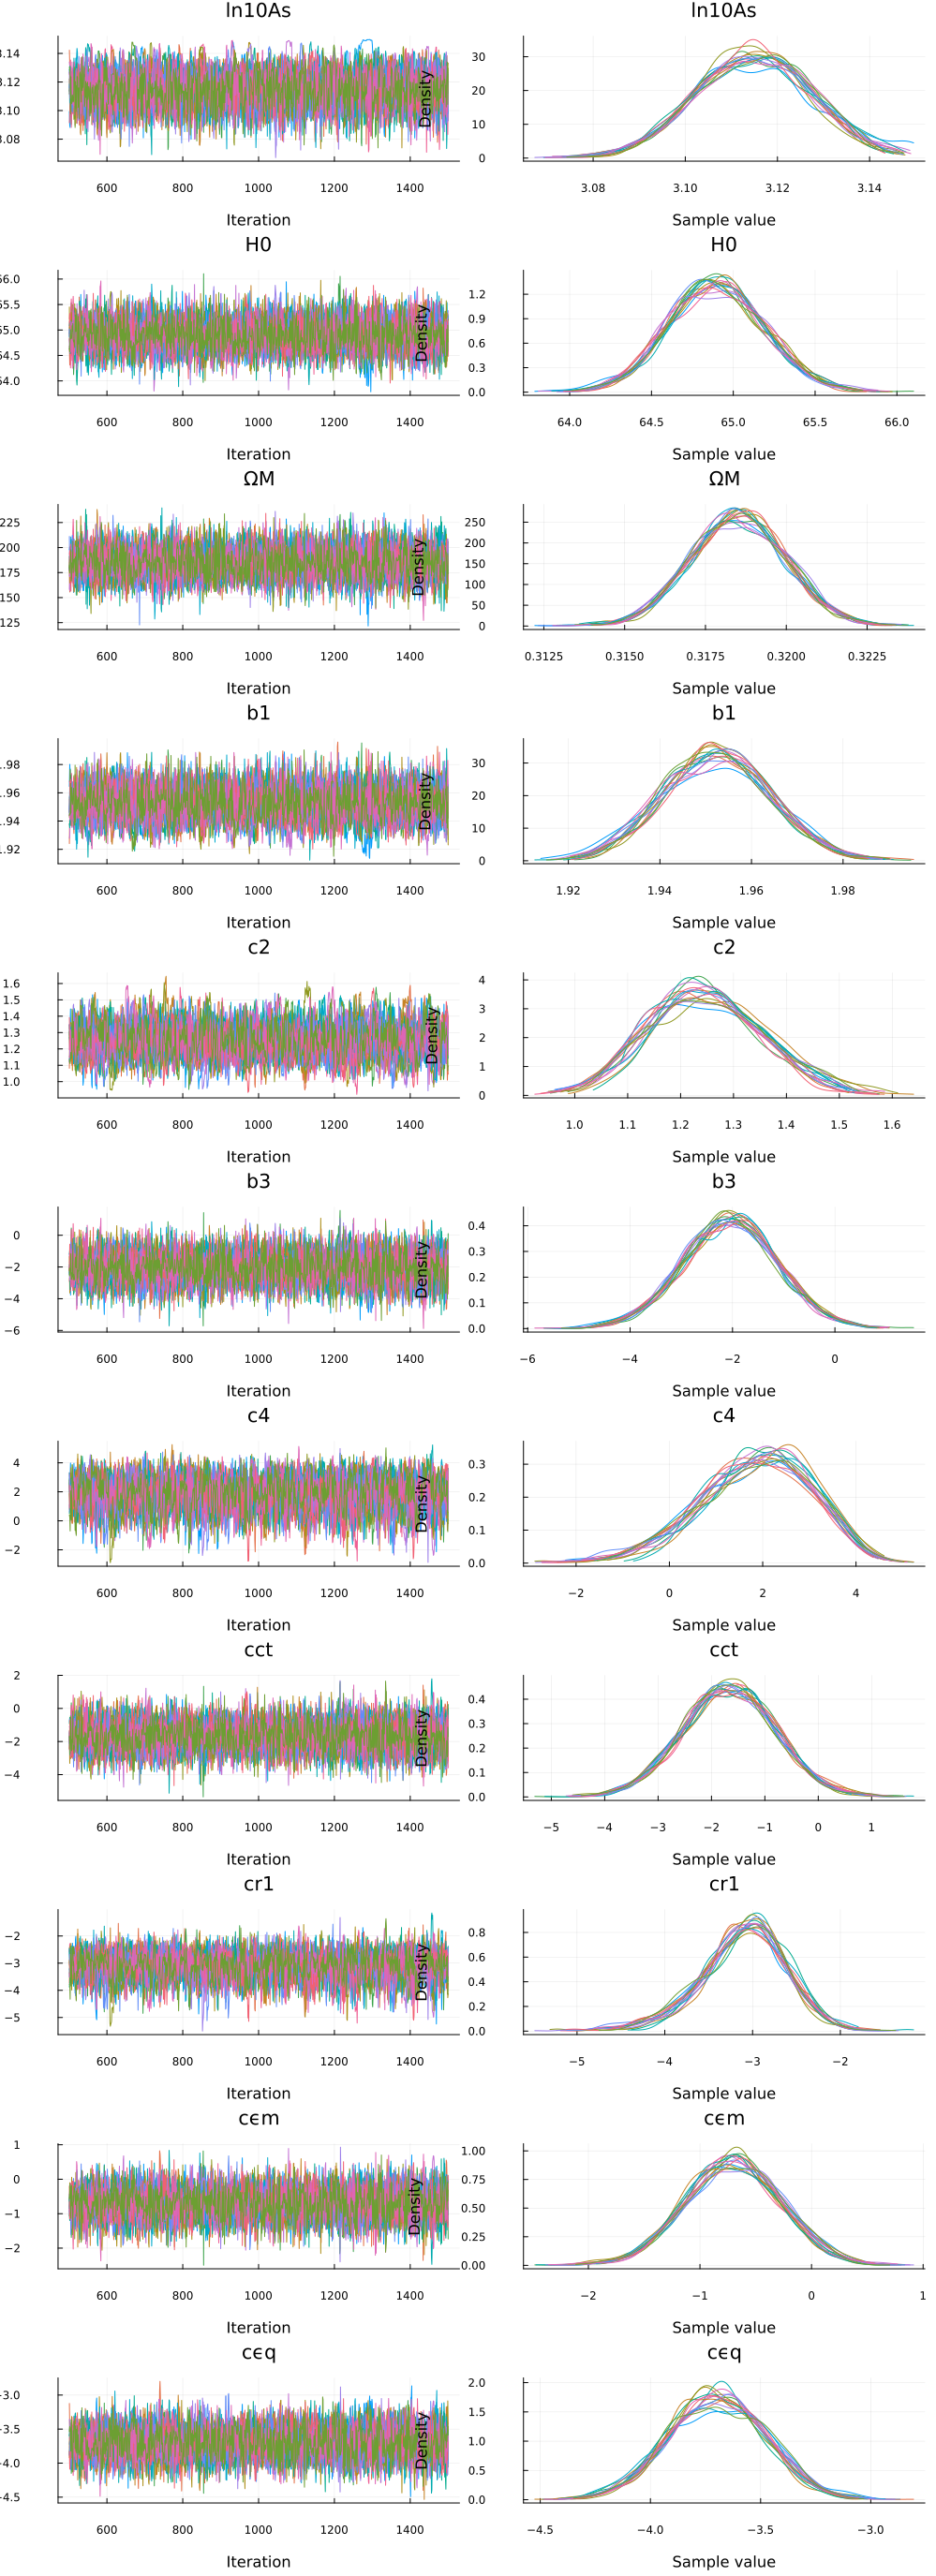

In [15]:
p = plot(chains_20)
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_20.pdf")
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_20.png")
p

In [16]:
function transpose_samples_single_chain_HMC(sample)
    save_sample = zeros(length(sample[:,1]), 11)
    for i in 1:11
        save_sample[:,i] = sample[:,i]
    end
    return save_sample
end

function process_chain(chains, nchains, n_samples)
    ln_10_As = zeros(nchains, n_samples)
    H0 = zeros(nchains, n_samples)
    ΩM = zeros(nchains, n_samples)
    b1 = zeros(nchains, n_samples)
    c2 = zeros(nchains, n_samples)
    c4 = zeros(nchains, n_samples)


    for i in 1:nchains
        chains_20 = transpose_samples_single_chain_HMC(chains.value.data[:,1:11,i])
        ln_10_As[i, :] = chains_20[:,1]
        H0[i, :] = chains_20[:,2]
        ΩM[i, :] = chains_20[:,3]
        b1[i, :] = chains_20[:,4]
        c2[i, :] = chains_20[:,5]
        c4[i, :] = chains_20[:,7]
    end

    my_ln_10_As = reshape(ln_10_As, nchains * n_samples)
    my_H0 = reshape(H0, nchains * n_samples)
    my_ΩM = reshape(ΩM, nchains * n_samples)
    my_b1 = reshape(b1, nchains * n_samples)
    my_c2 = reshape(c2, nchains * n_samples)
    my_c4 = reshape(c4, nchains * n_samples)
    println("ln_10_As mean is ",mean(my_ln_10_As), " and the std is ",std(my_ln_10_As),".")
    println("H0 mean is ",mean(my_H0), " and the std is ",std(my_H0),".")
    println("ΩM mean is ",mean(my_ΩM), " and the std is ",std(my_ΩM),".")
    println("b1 mean is ",mean(my_b1), " and the std is ",std(my_b1),".")
    println("c2 mean is ",mean(my_c2), " and the std is ",std(my_c2),".")
    println("c4 mean is ",mean(my_c4), " and the std is ",std(my_c4),".")

    x = zeros(length(my_ln_10_As), 6)
    x[:,1] = my_ΩM
    x[:,2] = my_H0
    x[:,3] = my_ln_10_As
    x[:,4] = my_b1
    x[:,5] = my_c2
    x[:,6] = my_c4
    return x
end

process_chain (generic function with 1 method)

In [17]:
x = process_chain(chains_20, nchains, nsteps)
npzwrite("my_chains_20_"*resum*scaling_name*"_Pathfinder_NUTS.npy", x)

ln_10_As mean is 3.114877905828684 and the std is 0.01268622439936634.
H0 mean is 64.89731400070518 and the std is 0.29398837986168286.
ΩM mean is 0.3185212789052973 and the std is 0.0014726141073986238.
b1 mean is 1.9525356848423607 and the std is 0.011811723554830017.
c2 mean is 1.2483976795815632 and the std is 0.10753573054824637.
c4 mean is 1.8677271421236348 and the std is 1.1889228718002136.


## $k_\mathrm{max}=0.18$

In [ ]:
n = 18

data_18, k_18, cov_18, yerror_Mono_18, yerror_Quad_18 = BlindedChallenge.create_data(n)

model_18 = pplmodel(data_18, cov_18.*scaling_factor, n, Mono_Emu, Quad_Emu);

In [ ]:
@time bestfit_18 = optimize(model_18, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
init_params_18 = [bestfit_18.values.array for i in 1:nchains]

In [ ]:
chains_18 = sample(model_18, Turing.NUTS(nadapts, 0.95, metricT=AdvancedHMC.DenseEuclideanMetric), MCMCThreads(), nsteps, nchains; initial_params = init_params_18)

In [ ]:
p = plot(chains_18)
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_18.pdf")
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_18.png")
p

In [ ]:
x = process_chain(chains_18, nchains, nsteps)
npzwrite("my_chains_18_"*resum*scaling_name*"_Pathfinder_NUTS.npy", x)

## $k_\mathrm{max}=0.16$

In [ ]:
n = 16

data_16, k_16, cov_16, yerror_Mono_16, yerror_Quad_16 = BlindedChallenge.create_data(n)

model_16 = pplmodel(data_16, cov_16.*scaling_factor, n, Mono_Emu, Quad_Emu);

In [ ]:
@time bestfit_16 = optimize(model_16, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
init_params_16 = [bestfit_16.values.array for i in 1:nchains]

In [ ]:
chains_16 = sample(model_16, Turing.NUTS(nadapts, 0.95, metricT=AdvancedHMC.DenseEuclideanMetric), MCMCThreads(), nsteps, nchains; initial_params = init_params_16)

In [ ]:
p = plot(chains_16)
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_16.pdf")
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_16.png")
p

In [ ]:
x = process_chain(chains_16, nchains, nsteps)
npzwrite("my_chains_16_"*resum*scaling_name*"_Pathfinder_NUTS.npy", x)

## $k_\mathrm{max}=0.14$

In [ ]:
n = 14

data_14, k_14, cov_14, yerror_Mono_14, yerror_Quad_14 = BlindedChallenge.create_data(n)

model_14 = pplmodel(data_14, cov_14.*scaling_factor, n, Mono_Emu, Quad_Emu);

In [ ]:
@time bestfit_14 = optimize(model_14, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
init_params_14 = [bestfit_14.values.array for i in 1:nchains]

In [ ]:
chains_14 = sample(model_14, Turing.NUTS(nadapts, 0.95, metricT=AdvancedHMC.DenseEuclideanMetric), MCMCThreads(), nsteps, nchains; initial_params = init_params_14)

In [ ]:
p = plot(chains_14)
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_14.pdf")
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_14.png")
p

In [ ]:
x = process_chain(chains_14, nchains, nsteps)
npzwrite("my_chains_14_"*resum*scaling_name*"_Pathfinder_NUTS.npy", x)

## $k_\mathrm{max}=0.12$

In [ ]:
n = 12

data_12, k_12, cov_12, yerror_Mono_12, yerror_Quad_12 = BlindedChallenge.create_data(n)

model_12 = pplmodel(data_12, cov_12.*scaling_factor, n, Mono_Emu, Quad_Emu);

In [ ]:
@time bestfit_12 = optimize(model_12, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
init_params_12 = [bestfit_12.values.array for i in 1:nchains]

In [ ]:
chains_12 = sample(model_12, Turing.NUTS(nadapts, 0.95, metricT=AdvancedHMC.DenseEuclideanMetric), MCMCThreads(), nsteps, nchains; initial_params = init_params_12)

In [ ]:
p = plot(chains_12)
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_12.pdf")
savefig("chains_turing_"*resum*scaling_name*"_Pathfinder_12.png")
p

In [ ]:
x = process_chain(chains_12, nchains, nsteps)
npzwrite("my_chains_12_"*resum*scaling_name*"_Pathfinder_NUTS.npy", x)